In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lib import pipeline
from lib import data_gen
from mlreflect.models import DefaultTrainedModel, TrainedModel
from mlreflect.data_generation import ReflectivityGenerator
from mlreflect.training import InputPreprocessor, OutputPreprocessor
import tensorflow as tf
from tensorflow import keras
from mlreflect.curve_fitter import CurveFitter
from mlreflect.data_generation import interp_reflectivity
test_number_of_curves = 10240
test_values_per_curve = 109
PARAMETERS = ["Film_thickness", "Film_roughness", "Film_sld"]


In [19]:
noise_level=0.2
BATCH_SIZE=512

In [20]:
# model_cnn = keras.models.load_model(
#     'models/0.001_0.0_100_100_50_12_8_512_20220627-183255')
model_cnn = keras.models.load_model(
    'models/0.001_0.2_100_100_50_12_8_512_20220705-194014')

mean_labels, std_labels = np.loadtxt(
    "data/mean_labels.csv"), np.loadtxt("data/std_labels.csv")
mean_data, std_data = np.loadtxt(
    f"data/mean_data_{noise_level}.csv"), np.loadtxt(f"data/std_data_{noise_level}.csv")


In [21]:
def predict_mlp_syn(gen_test, ip, out, data_test_true_real_scale):
    reflectivity_true_unit_scale = ip.standardize(data_test_true_real_scale)
    model = DefaultTrainedModel().keras_model
    pred_params_unit_scale = model.predict(reflectivity_true_unit_scale)
    pred_params_real_scale_full = out.restore_labels(pred_params_unit_scale)
    reflectivity_sim = gen_test.simulate_reflectivity(
        pred_params_real_scale_full)
    print(model.summary())
    return reflectivity_sim, pred_params_real_scale_full


In [22]:
def predict_cnn_syn(generator, reflectivity_true_real_scale, labels):
    # model=keras.models.load_model('models/0.0_60_25_50_8_8_20220614-145228')
    # model=keras.models.load_model('models/0.01_0.0_90_30_15_4_2_20220616-174358')
    # model=keras.models.load_model('models/0.005_0.0_10_10_5_12_8_128_20220621-163229')
    # model=keras.models.load_model('models/0.001_0.0_50_30_15_12_8_1024_20220622-173759')
    # reflectivity_true_unit_scale = (
    #     reflectivity_true_real_scale-mean_data)/std_data

    reflectivity_true_real_scale = reflectivity_true_real_scale.reshape(
        test_number_of_curves, test_values_per_curve, 1)
    pred_params_true_scale_full = labels.copy()
    
    labels=labels.drop(labels.columns.difference(["Film_thickness", "Film_roughness", "Film_sld"]), axis=1)
    labels=labels.to_numpy()
    dataset=tf.data.Dataset.from_tensor_slices((reflectivity_true_real_scale, labels)).batch(BATCH_SIZE)
    pred_params_unit_scale = model_cnn.predict(dataset)
    pred_params_true_scale = pred_params_unit_scale*std_labels+mean_labels

    

    pred_params_true_scale_full["Film_thickness"] = pred_params_true_scale[:, 0]
    pred_params_true_scale_full["Film_roughness"] = pred_params_true_scale[:, 1]
    pred_params_true_scale_full["Film_sld"] = pred_params_true_scale[:, 2]
    print(pred_params_true_scale)
    reflectivity_sim = generator.simulate_reflectivity(
        pred_params_true_scale_full)
    print(model_cnn.summary())
    return reflectivity_sim, pred_params_true_scale_full


In [23]:
def make_analysis(reflectivity_true_real_scale, q_values, refl_sim_lst, params_cnn, params_mlp, labels):
    error_lst = np.zeros((len(reflectivity_true_real_scale)))
    fig_boxplot, axs_boxplot = plt.subplots(1, 2, sharey=True)
    fig_boxplots_param_errors, axs_boxplots_param_errors = plt.subplots(
        1, 3, figsize=(10, 5))
    fig_boxplots_param_errors_rel, axs_boxplots_param_errors_rel = plt.subplots(
        1, 3, figsize=(10, 5))
    fig, axs = plt.subplots(5, 5, figsize=(15, 10), sharex=True)
    fig.suptitle(
        "Ground truth vs. Predicted curves (simulations, no noise, pseudo test)")
    fig_boxplot.suptitle("Statistical comparison")

    for idx, modelname in enumerate(["mlp", "cnn"]):
        for idx_lineplot, ax in enumerate(axs.flat):
            ax.semilogy(
                q_values, refl_sim_lst[idx][idx_lineplot], label=f"predicted_{modelname}")

        for curve_number, (curve_true, curve_sim) in enumerate(zip(reflectivity_true_real_scale, refl_sim_lst[idx])):
            curve_true = curve_true.reshape(test_values_per_curve)
            error_lst[curve_number] = pipeline.log_error(curve_true, curve_sim)

        axs_boxplot[idx].boxplot(error_lst, showfliers=False)
        axs_boxplot[idx].set_title("mean-log-error")
        axs_boxplot[idx].set_xticklabels([f"{modelname}"])

    for idx, (box, param) in enumerate(zip(axs_boxplots_param_errors, PARAMETERS)):
        box.boxplot([np.absolute(params_mlp[param]-labels[param]),
                    np.absolute(params_cnn[param]-labels[param])], showfliers=False)
        box.set_title(f"Absolute error: {param}")
        box.set_xticklabels(["MLP", "CNN"])

    for idx, (box, param) in enumerate(zip(axs_boxplots_param_errors_rel, PARAMETERS)):
        box.boxplot([100*np.absolute(params_mlp[param]-labels[param])/labels[param], 100 *
                    np.absolute(params_cnn[param]-labels[param])/labels[param]], showfliers=False)  # outliers?
        box.set_title(f"Relative error: {param}")
        box.set_xticklabels(["MLP", "CNN"])

    for idx, ax in enumerate(axs.flat):
        ax.semilogy(
            q_values, reflectivity_true_real_scale[idx], label="ground truth")
        ax.legend()
    fig.tight_layout()
    fig_boxplots_param_errors.tight_layout()


In [24]:
def visualize_comparison():
    q_values = DefaultTrainedModel().q_values
    sample = DefaultTrainedModel().sample
    generator = ReflectivityGenerator(q_values, sample)
    labels = generator.generate_random_labels(test_number_of_curves)
    ip = InputPreprocessor()
    out = OutputPreprocessor(sample)
    reflectivity_true_real_scale = generator.simulate_reflectivity(labels)
    refl_sim_lst = []
    reflectivity_sim_mlp, params_mlp = predict_mlp_syn(
        generator, ip, out, reflectivity_true_real_scale)
    refl_sim_lst.append(reflectivity_sim_mlp)

    reflectivity_sim_cnn, params_cnn = predict_cnn_syn(
        generator, reflectivity_true_real_scale, labels)
    refl_sim_lst.append(reflectivity_sim_cnn)

    make_analysis(reflectivity_true_real_scale, q_values,
                  refl_sim_lst, params_cnn, params_mlp, labels)

100%|██████████| 10240/10240 [00:00<00:00, 15094.68it/s]


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 500)               55000     
_________________________________________________________________
activation_9 (Activation)    (None, 500)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 500)               250500    
_________________________________________________________________
activation_10 (Activation)   (None, 500)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 500)               250500    
_________________________________________________________________
activation_11 (Activation)   (None, 500)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 3)                

 14%|█▎        | 1394/10240 [00:00<00:00, 13931.34it/s]

[[394.73062013  33.00682245  12.94168685]
 [130.71443039  35.36579154  12.41424176]
 [477.29210607  67.97188756   7.24272093]
 ...
 [758.69126298  61.1568887    6.73016502]
 [836.01094929   9.68512553   6.58249973]
 [568.52865083  88.67294781  10.84728136]]


100%|██████████| 10240/10240 [00:00<00:00, 14929.86it/s]


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
noise_and_standardize (noise multiple                  0         
_________________________________________________________________
input_2 (InputLayer)         [(None, 109, 1)]          0         
_________________________________________________________________
conv1d (Conv1D)              multiple                  1300      
_________________________________________________________________
max_pooling1d (MaxPooling1D) multiple                  0         
_________________________________________________________________
conv1d_1 (Conv1D)            multiple                  40050     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 multiple                  0         
_________________________________________________________________
flatten (Flatten)            multiple                  0

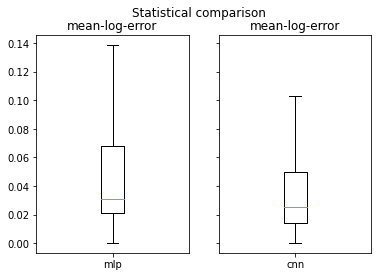

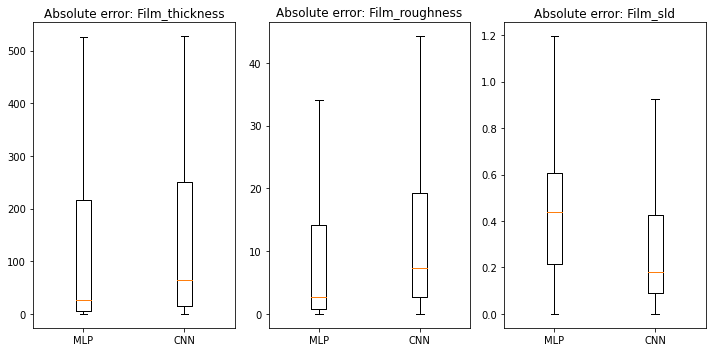

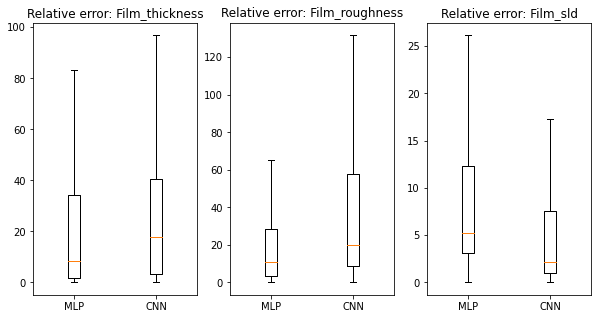

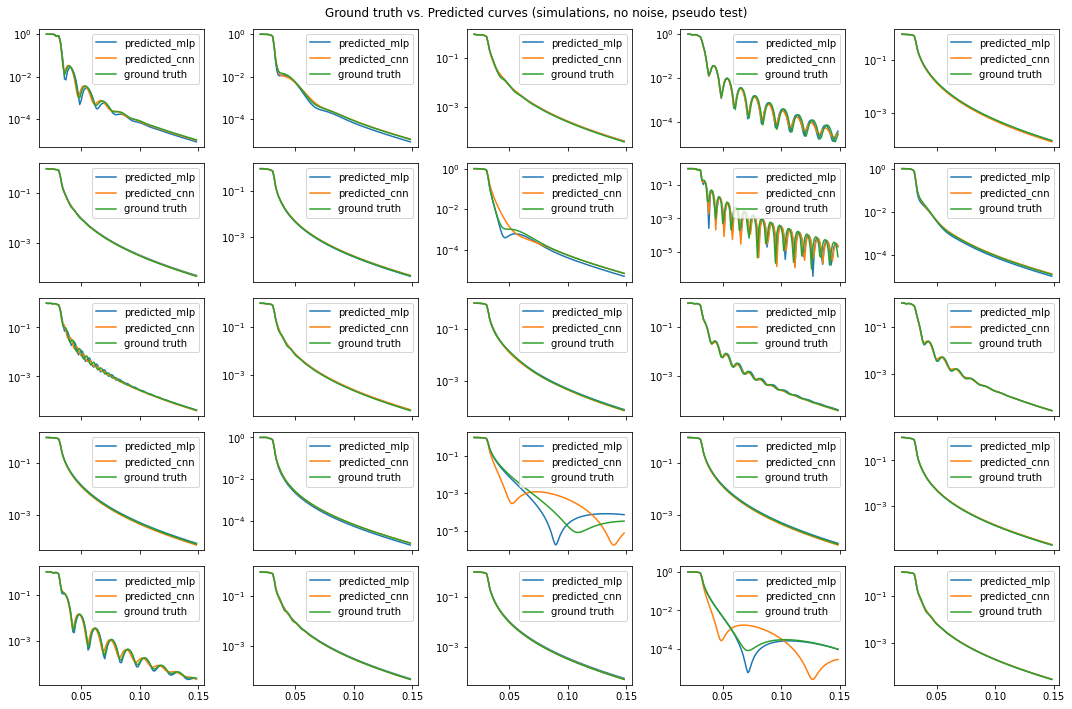

In [25]:
visualize_comparison()

In [26]:
def visualize_experimental_performance():

    q_values_used_for_training = DefaultTrainedModel().q_values
    sample = DefaultTrainedModel().sample
    model_mlp = DefaultTrainedModel()
    fig_boxplot, axs_boxplot = plt.subplots(1, sharey=True)
    fig_boxplots_param_errors, axs_boxplots_param_errors = plt.subplots(
        1, 3, figsize=(10, 5))
    fig_boxplot.suptitle("Statistical comparison")

    # beim laden refl und q werte zusammen streichen.PARAMETERS = ["Film_thickness", "Film_roughness", "Film_sld"]
    test_refl_lst, test_q_values_lst, test_lables_lst = data_gen.iterate_experiments()

    th_lst_cnn, rh_lst_cnn, sld_lst_cnn, refl_sim_lst_cnn, log_error_lst_cnn = pipeline.pred_and_calculate_errors(
        test_refl_lst, test_q_values_lst, test_lables_lst, q_values_used_for_training, "CNN", sample, model_cnn, noise_level, mean_labels, std_labels, mean_data, std_data)
    th_lst_mlp, rh_lst_mlp, sld_lst_mlp, refl_sim_lst_mlp, log_error_lst_mlp = pipeline.pred_and_calculate_errors(
        test_refl_lst, test_q_values_lst, test_lables_lst, q_values_used_for_training, "MLP", sample, model_mlp, noise_level, mean_labels, std_labels, mean_data, std_data)

    for param_idx, (param_lst_cnn, param_lst_mlp) in enumerate(zip([th_lst_cnn, rh_lst_cnn, sld_lst_cnn], [th_lst_mlp, rh_lst_mlp, sld_lst_mlp])):
        axs_boxplots_param_errors[param_idx].boxplot(
            [param_lst_mlp, param_lst_cnn], positions=[1, 2], showfliers=False)
    for ax_idx, ax in enumerate(axs_boxplots_param_errors):
        axs_boxplots_param_errors[ax_idx].set_xticklabels(["MLP", "CNN"])
        axs_boxplots_param_errors[ax_idx].set_title(PARAMETERS[ax_idx])
    axs_boxplot.boxplot(
        [log_error_lst_mlp, log_error_lst_cnn], showfliers=False)
    axs_boxplot.set_xticklabels(["MLP", "CNN"])

    fig_boxplot.suptitle(f"mean-log-error on 240 experimental curves")
    fig_boxplots_param_errors.suptitle(
        f"Parameter errors on 240 experimental curves both models trained on optimal noise levels (MLP: 0.3, CNN: {noise_level})")
# # Kurvenvergleich mit Cropping von experimentaldaten


CNN: 
Exp Median param errors: 33.49843300699474 3.834339457121816 0.8468715854866797
Exp Median log error: 0.2932057343015337
MLP: 
Exp Median param errors: 6.420796792074789 1.7280227407821087 0.7923725134125156
Exp Median log error: 0.14872632537257507


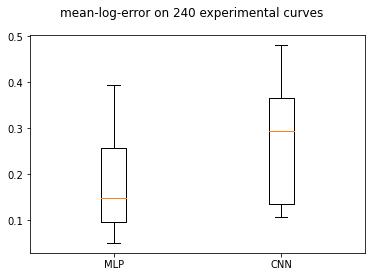

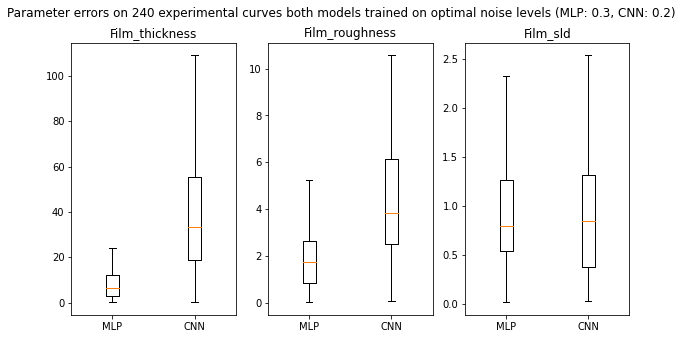

In [27]:
visualize_experimental_performance()